In [1]:
from main import MainProgram
import numpy as np
import pandas as pd
from matplotlib import pyplot
import os
import main
import importlib
importlib.reload(main)
from scipy.interpolate import griddata

In [2]:
target = 'LHS1140b'  # Exoplanet name

out_file = f"simulation_results_{target}.txt"
if os.path.exists(out_file):
    os.remove(out_file)
    print(f"Previous file '{out_file}' removed. Creating a new one...")
else:
    print(f"No existing file named '{out_file}'. A new one will be created...")

############## Code Parameters - No changes required ############################

intensidadeMaxima = 1000
min_pixels = 100 # minimum allowed matrix size
max_pixels = 2000 # maximum allowed matrix size
pixels_per_rp = 55 # desired pixels per planetary radius

Previous file 'simulation_results_LHS1140b.txt' removed. Creating a new one...


In [3]:
############## Main Parameters ############################

########## Star #################
raioStar = 0.2159 # [R_sun]
massStar = 0.1844 # [M_sun]
tempStar = 3100 # [K]
######### Planet ################
raioPlanetaRj = 0.1543 # [Rj] (in in jupiter's radius)
######### Orbital Parameters ####
periodo = 24.73723 # [days]
anguloInclinacao = 89.86 # [deg]
semiEixoUA = 0.0946 # [AU]
ecc = 0
anom = 0

In [4]:
############## Plot Options ###############################

plot_anim = False
plot_star = False
plot_graph = False

In [5]:
############## LD Coefficients ############################


# Define column names manually (based on your file)
column_names = [
    'Teff', 'logg', 'FeH', 'profile', 'filter',
    'wave_min', 'wave_eff', 'wave_max',
    'c1', 'e1', 'c2', 'e2', 'c3', 'e3', 'c4', 'e4'
]

# Read the file, skipping the first 2 lines: header + dashed line
table_ExoCTK = pd.read_csv(
    'ExoCTK_results.txt',
    sep=r'\s+',              # Use regex to split on variable whitespace
    skiprows=2,              # Skip header and separator line
    names=column_names,      # Use correct column names
    engine='python',         # Regex splitting requires python engine
    keep_default_na=False
)

# Now the data is usable as expected
c1 = table_ExoCTK['c1'].to_numpy()
c2 = table_ExoCTK['c2'].to_numpy()
c3 = table_ExoCTK['c3'].to_numpy()
c4 = table_ExoCTK['c4'].to_numpy()

unique_profiles = table_ExoCTK['profile'].unique()
if len(unique_profiles) == 1:
    profile = unique_profiles[0]
else:
    print("Warning: Multiple profile types found:", unique_profiles)


lambdaEff = table_ExoCTK['wave_eff'].astype(float).to_numpy()

num_elements = len(c1)

In [6]:
############## Starspots/Faculae ##########################

starspots = True # Caution! Do not change to False
lat = np.array([20, 20, 20]) # [deg] 
longt = np.array([-20, 0, 20]) # [deg]
quantidade = len(lat)

In [7]:
############## Interpolation Parameters ###################

# Spot simulation parameters
ff_spot_min = 0.01
ff_spot_max = 0.15
T_spot_min = tempStar - 300
T_spot_max = tempStar - 5
num_ff_spot_simulations = 5
num_T_spot_simulations = 5

# Facula simulation parameters
ff_fac_min = 0.01
ff_fac_max = 0.15
T_fac_min = tempStar + 5
T_fac_max = tempStar + 300
num_ff_fac_simulations = 5
num_T_fac_simulations = 5

# Interpolation parameters. This is the grid for retrievals
num_ff_interpolations = 30 # Number of interpolations for filling factor
num_T_spot_interpolations = 30 # Number of interpolations for temperature


Running the unspotted scenario (ff=0) first, so it appears first in the results file.
Running simulation for unspotted with ff=0.0 and T=nan
stellar effective temperature: 3100
active region effective temperature: nan
Matrix size [px]:  1686
Star radius size [px]:  766.5230776287523
Starting the simulation 1 of 5
Starting the simulation 2 of 5
Starting the simulation 3 of 5
Starting the simulation 4 of 5
Starting the simulation 5 of 5


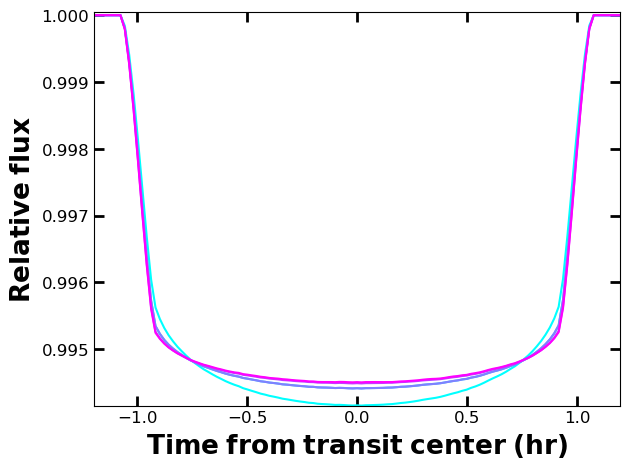

>>> Baseline computed and stored in memory.
Running simulation for spot with ff=0.01 and T=2800.0
stellar effective temperature: 3100
active region effective temperature: 2800.0
Matrix size [px]:  1686
Star radius size [px]:  766.5230776287523
Starting the simulation 1 of 5
Starting the simulation 2 of 5
Starting the simulation 3 of 5
Starting the simulation 4 of 5


KeyboardInterrupt: 

In [8]:
def interpolate_results(input_file, ff_interp, T_spot_interp):
    """
    Interpolates the results of the simulations to generate additional data points.

    Parameters:
        input_file (str): Path to the simulation results file.
        ff_interp (np.ndarray): Array of filling factors for interpolation.
        T_spot_interp (np.ndarray): Array of T_spot values for interpolation.

    Returns:
        interpolated_data (np.ndarray): Interpolated results (ff, T_spot, lambdaEff_nm, D_lambda).
    """
    # Load simulation data
    data = np.loadtxt(input_file, delimiter=',', skiprows=1)
    f_spot_array, tempSpot_array, lambdaEff_nm, D_lambda = data.T

    # Create points array as pairs of (ff, T_spot)
    points = np.column_stack((f_spot_array, tempSpot_array))
    
    # Create a mask that filters out any row with a NaN value
    valid_mask = ~np.isnan(points).any(axis=1)
    
    # Filter the data using the valid_mask
    points_valid = points[valid_mask]
    values_valid = D_lambda[valid_mask]
    lambdaEff_valid = lambdaEff_nm[valid_mask]

    # Define the interpolation grid
    ff_grid, T_spot_grid = np.meshgrid(ff_interp, T_spot_interp)

    # Perform interpolation for each unique wavelength using valid data only
    interpolated_data = []
    unique_wavelengths = np.unique(lambdaEff_valid)
    for wavelength in unique_wavelengths:
        # Mask valid data for the current wavelength
        wl_mask = (lambdaEff_valid == wavelength)
        if np.sum(wl_mask) == 0:
            continue  # Skip if no data for this wavelength

        # Interpolate using griddata
        interp_vals = griddata(
            points_valid[wl_mask],
            values_valid[wl_mask],
            (ff_grid.ravel(), T_spot_grid.ravel()),
            method='linear'
        )
        # Append each interpolated point with its wavelength
        for ff_val, T_val, interp_D_lambda in zip(ff_grid.ravel(), T_spot_grid.ravel(), interp_vals):
            interpolated_data.append([ff_val, T_val, wavelength, interp_D_lambda])

    return np.array(interpolated_data)

def run_simulations(ff_min, ff_max, T_spot_min, T_spot_max,
                    num_ff_simulations, num_T_spot_simulations,
                    other_params, result_type):
    """
    Executes simulations for a grid of ff and T_spot values.

    Parameters:
        ff_min (float): Minimum value for ff.
        ff_max (float): Maximum value for ff.
        T_spot_min (float): Minimum value for T_spot.
        T_spot_max (float): Maximum value for T_spot.
        num_ff_simulations (int): Number of simulations in ff.
        num_T_spot_simulations (int): Number of simulations in T_spot.
        other_params (dict): Fixed parameters for the main program execution.
        result_type (str): Type of the simulation ("spot", "faculae", or "unspotted").

    Returns:
        (simulated_ff, simulated_T_spot): Arrays of ff and T_spot used in the simulations.
    """
    grid_ff = np.linspace(ff_min, ff_max, num_ff_simulations)
    grid_T_spot = np.linspace(T_spot_min, T_spot_max, num_T_spot_simulations)

    for ff in grid_ff:
        for T_spot in grid_T_spot:
            if not (0 <= ff <= 1):
                raise ValueError(f"ff={ff} is out of range [0, 1].")

            # If there are multiple starspots, each spot receives a proportional filling factor
            quantidade = max(other_params.get('quantidade', 1), 1)  # Ensure it's at least 1
            ff_per_spot = ff / quantidade  # Distribute the filling factor equally among the spots
            spot_radius = np.sqrt(ff_per_spot)  # Convert to individual spot radius

            iteration_params = other_params.copy()
            iteration_params['r'] = spot_radius
            iteration_params['tempSpot'] = T_spot

            print(f"Running simulation for {result_type} with ff={ff} and T={T_spot}")

            # Executes the MainProgram with the updated parameters
            MainProgram(
                target=target,
                num_elements=iteration_params['num_elements'],
                profile=iteration_params['profile'],
                c1=iteration_params['c1'],
                c2=iteration_params['c2'],
                c3=iteration_params['c3'],
                c4=iteration_params['c4'],
                lambdaEff=iteration_params['lambdaEff'],
                intensidadeMaxima=iteration_params['intensidadeMaxima'],
                raioStar=iteration_params['raioStar'],
                ecc=iteration_params['ecc'],
                anom=iteration_params['anom'],
                tempStar=iteration_params['tempStar'],
                starspots=iteration_params['starspots'],
                quantidade=iteration_params['quantidade'],
                lat=iteration_params['lat'],       # Mantido como array
                longt=iteration_params['longt'],     # Mantido como array
                r=iteration_params['r'],
                semiEixoUA=iteration_params['semiEixoUA'],
                massStar=iteration_params['massStar'],
                plot_anim=iteration_params['plot_anim'],
                periodo=iteration_params['periodo'],
                anguloInclinacao=iteration_params['anguloInclinacao'],
                raioPlanetaRj=iteration_params['raioPlanetaRj'],
                plot_graph=iteration_params['plot_graph'],
                plot_star=iteration_params['plot_star'],
                tempSpot=iteration_params['tempSpot'],
                min_pixels=iteration_params['min_pixels'],
                max_pixels=iteration_params['max_pixels'],
                pixels_per_rp=iteration_params['pixels_per_rp']
            )

    return grid_ff, grid_T_spot

other_params = {
    'num_elements': num_elements,
    'profile': profile,
    'c1': c1,
    'c2': c2,
    'c3': c3,
    'c4': c4,
    'lambdaEff': lambdaEff,
    'target': target,
    'intensidadeMaxima': intensidadeMaxima,
    'raioStar': raioStar,
    'ecc': ecc,
    'anom': anom,
    'tempStar': tempStar,
    'starspots': starspots,
    'quantidade': quantidade,
    'lat': lat,
    'longt': longt,
    'semiEixoUA': semiEixoUA,
    'massStar': massStar,
    'plot_anim': plot_anim,
    'periodo': periodo,
    'anguloInclinacao': anguloInclinacao,
    'raioPlanetaRj': raioPlanetaRj,
    'plot_graph': plot_graph,
    'plot_star': plot_star,
    'min_pixels': min_pixels,
    'max_pixels': max_pixels,
    'pixels_per_rp': pixels_per_rp
}

############################################################################
# 1) RUN THE UNSPOTTED SCENARIO FIRST (ff=0), tempSpot = NaN
############################################################################

count = 0
while count == 0:
    
    starspots = False
    print("\nRunning the unspotted scenario (ff=0) first, so it appears first in the results file.")

    unspotted_params = other_params.copy()
    unspotted_params['r'] = 0.0                # => ff=0 => unspotted
    unspotted_params['tempSpot'] = float('nan')  # no valid temperature for a spot

    # Here we call run_simulations with ff_min=0, ff_max=0, T_spot_min=NaN, T_spot_max=NaN
    # and only 1 step for each, so it simulates a single unspotted point.
    run_simulations(
        ff_min=0.0, 
        ff_max=0.0, 
        T_spot_min=float('nan'), 
        T_spot_max=float('nan'), 
        num_ff_simulations=1, 
        num_T_spot_simulations=1, 
        other_params=unspotted_params, 
        result_type="unspotted"
    )
    
    count = count+1

#######################################################################################

starspots = True

# 2) Run simulations for spots
run_simulations(
    ff_spot_min, ff_spot_max, T_spot_min, T_spot_max,
    num_ff_spot_simulations, num_T_spot_simulations,
    other_params, "spot"
)

# 3) Run simulations for faculae
run_simulations(
    ff_fac_min, ff_fac_max, T_fac_min, T_fac_max,
    num_ff_fac_simulations, num_T_fac_simulations,
    other_params, "faculae"
)

print(f"Simulations completed for {target}. Results saved in 'simulation_results_{target}.txt'.")

C:\Users\vikto\AppData\Local\Temp\ipykernel_31024\302794212.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_f = get_cmap("winter_r")
C:\Users\vikto\AppData\Local\Temp\ipykernel_31024\302794212.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_t = get_cmap("cool_r")


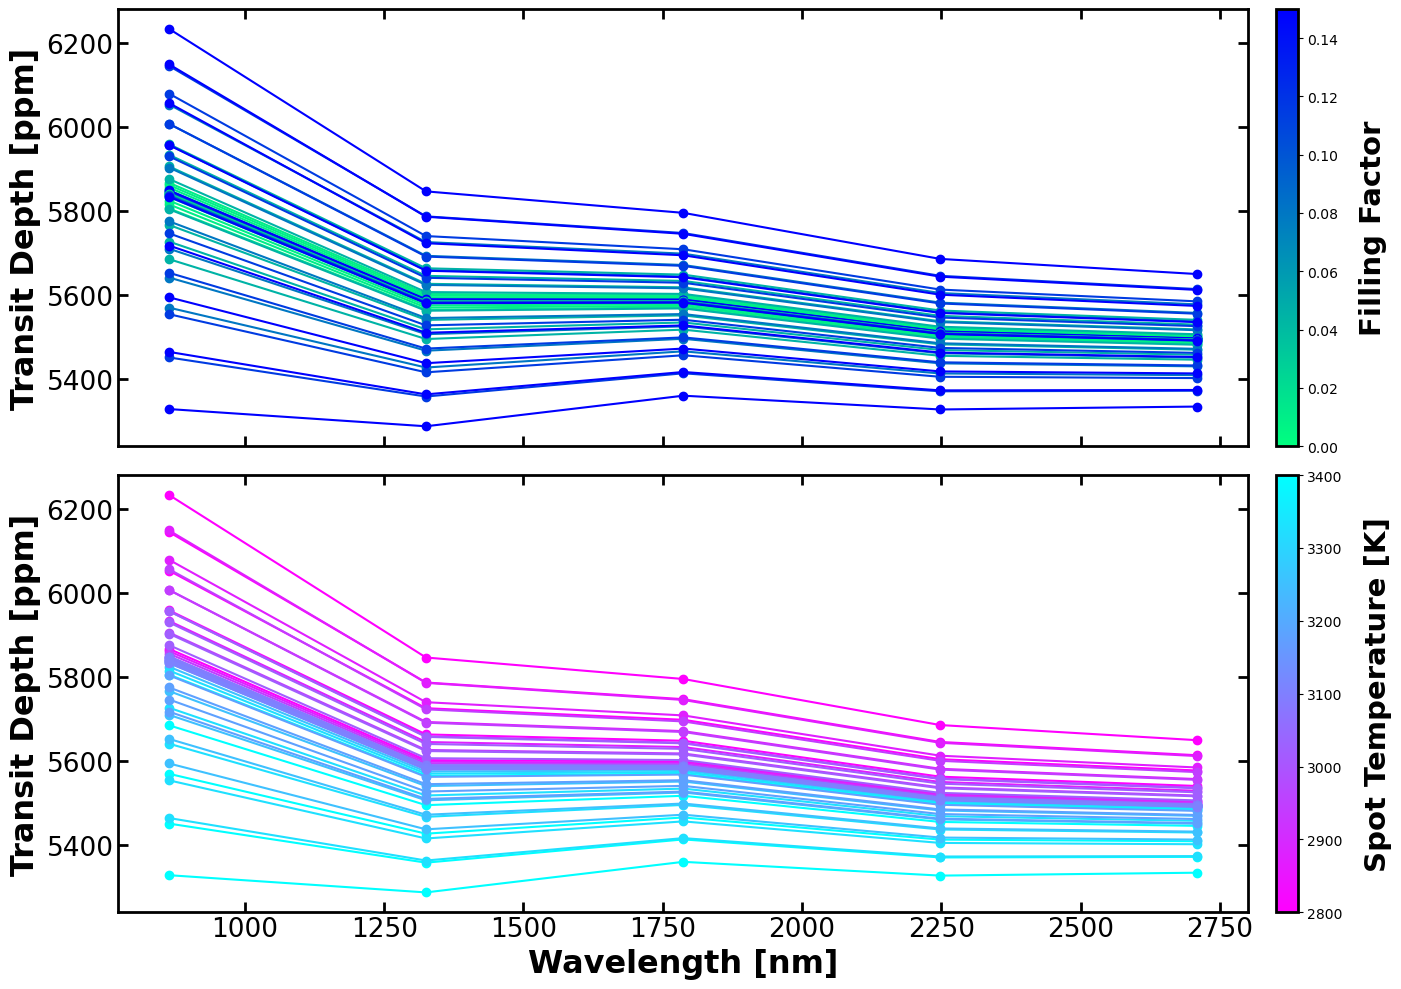

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import os

###############################################################################
# 1) Leitura dos dados e agrupamento
###############################################################################
file_path = f"simulation_results_{target}.txt"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# Carrega usando nomes de coluna (names=True), assumindo CSV com cabeçalho:
# f_spot,tempSpot,wavelength,D_lambda
data = np.genfromtxt(file_path, delimiter=',', names=True)

f_spot_array = data['f_spot']
tempSpot_array = data['tempSpot']
lambdaEff_nm = data['wavelength']
D_lambda = data['D_lambda']

# Vamos agrupar todos os pontos com (f_spot, tempSpot) em um dicionário.
lines_dict = {}
for i in range(len(f_spot_array)):
    f_spot_val = f_spot_array[i]
    t_spot_val = tempSpot_array[i]
    lam = lambdaEff_nm[i]
    dval = D_lambda[i]
    
    # (Opcional) Arredonde para evitar duplicações por flutuação de ponto flutuante
    # Exemplo: f_spot_val = round(f_spot_val, 5)

    key = (f_spot_val, t_spot_val)
    if key not in lines_dict:
        lines_dict[key] = {'lambda': [], 'D': []}
    lines_dict[key]['lambda'].append(lam)
    lines_dict[key]['D'].append(dval)

###############################################################################
# 2) Plot: cada combinação (f_spot, tempSpot) vira uma única linha
###############################################################################
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# -- Primeiro subplot: color por f_spot --
f_spot_vals = np.array([k[0] for k in lines_dict.keys()])
f_spot_min, f_spot_max = np.nanmin(f_spot_vals), np.nanmax(f_spot_vals)

cmap_f = get_cmap("winter_r")
norm_f = Normalize(vmin=f_spot_min, vmax=f_spot_max)

for (f_spot_val, t_spot_val), values in lines_dict.items():
    lam_array = np.array(values['lambda'])
    d_array   = np.array(values['D'])
    
    # Ordena por wavelength para não "zigzaguear"
    idx = np.argsort(lam_array)
    lam_array = lam_array[idx]
    d_array   = d_array[idx]
    
    color = cmap_f(norm_f(f_spot_val))
    ax1.plot(lam_array, d_array, marker='o', linestyle='-', color=color, alpha=1)

# Adiciona colorbar de f_spot
sm_f = ScalarMappable(cmap=cmap_f, norm=norm_f)
sm_f.set_array([])  # Array vazio, pois já temos min/max
cbar1 = fig.colorbar(sm_f, ax=ax1, orientation='vertical', pad=0.02)
cbar1.set_label("Filling Factor", fontsize=21, fontweight='bold', labelpad=15)

# Personalização do subplot 1
ax1.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
ax1.tick_params(axis="x", direction="in", labelsize=19, width=2, length=7, pad=3, top=True)
ax1.tick_params(axis="y", direction="in", labelsize=19, width=2, length=7, pad=3, right=True)

# -- Segundo subplot: color por tempSpot (só valores válidos) --
# Se não quiser ignorar NaN, basta retirar o if ~np.isnan(t_spot_val)
temp_vals = np.array([k[1] for k in lines_dict.keys() if not np.isnan(k[1])])
t_min, t_max = np.nanmin(temp_vals), np.nanmax(temp_vals)

cmap_t = get_cmap("cool_r")
norm_t = Normalize(vmin=t_min, vmax=t_max)

for (f_spot_val, t_spot_val), values in lines_dict.items():
    # Se tempSpot for NaN, pula
    if np.isnan(t_spot_val):
        continue

    lam_array = np.array(values['lambda'])
    d_array   = np.array(values['D'])
    
    idx = np.argsort(lam_array)
    lam_array = lam_array[idx]
    d_array   = d_array[idx]
    
    color = cmap_t(norm_t(t_spot_val))
    ax2.plot(lam_array, d_array, marker='o', linestyle='-', color=color, alpha=1)

# Adiciona colorbar de tempSpot
sm_t = ScalarMappable(cmap=cmap_t, norm=norm_t)
sm_t.set_array([])
cbar2 = fig.colorbar(sm_t, ax=ax2, orientation='vertical', pad=0.02)
cbar2.set_label("Spot Temperature [K]", fontsize=21, fontweight='bold', labelpad=15)

# Personalização do subplot 2
ax2.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
ax2.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
ax2.tick_params(axis="x", direction="in", labelsize=19, width=2, length=7, pad=3, top=True)
ax2.tick_params(axis="y", direction="in", labelsize=19, width=2, length=7, pad=3, right=True)

plt.tight_layout()
plt.show()


In [ ]:
# Define ranges for spot interpolation
ff_spot_interp = np.linspace(ff_spot_min, ff_spot_max, num_ff_interpolations)
T_spot_interp = np.linspace(T_spot_min, T_spot_max, num_T_spot_interpolations)

# Interpolate spot results
file_path = f"simulation_results_{target}.txt"
interpolated_spot_data = interpolate_results(file_path, ff_spot_interp, T_spot_interp)

# Define ranges for facula interpolation
ff_fac_interp = np.linspace(ff_fac_min, ff_fac_max, num_ff_interpolations)
T_fac_interp = np.linspace(T_fac_min, T_fac_max, num_T_spot_interpolations)

# Interpolate facula results
file_path = f"simulation_results_{target}.txt"
interpolated_fac_data = interpolate_results(file_path, ff_fac_interp, T_fac_interp)

# Combine interpolated results for spots and faculae
combined_interpolated_data = pd.concat(
    [
        pd.DataFrame(interpolated_spot_data, columns=["ff", "T", "lambdaEff_nm", "D_lambda"]).assign(type="spot"),
        pd.DataFrame(interpolated_fac_data, columns=["ff", "T", "lambdaEff_nm", "D_lambda"]).assign(type="facula")
    ],
    ignore_index=True
)

# Save the combined results into a single file
combined_interpolated_data.to_csv(
    f"interpolated_results_{target}.txt",
    index=False
)

C:\Users\vikto\AppData\Local\Temp\ipykernel_31024\2888972163.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_f = get_cmap("winter_r")
C:\Users\vikto\AppData\Local\Temp\ipykernel_31024\2888972163.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_t = get_cmap("cool_r")


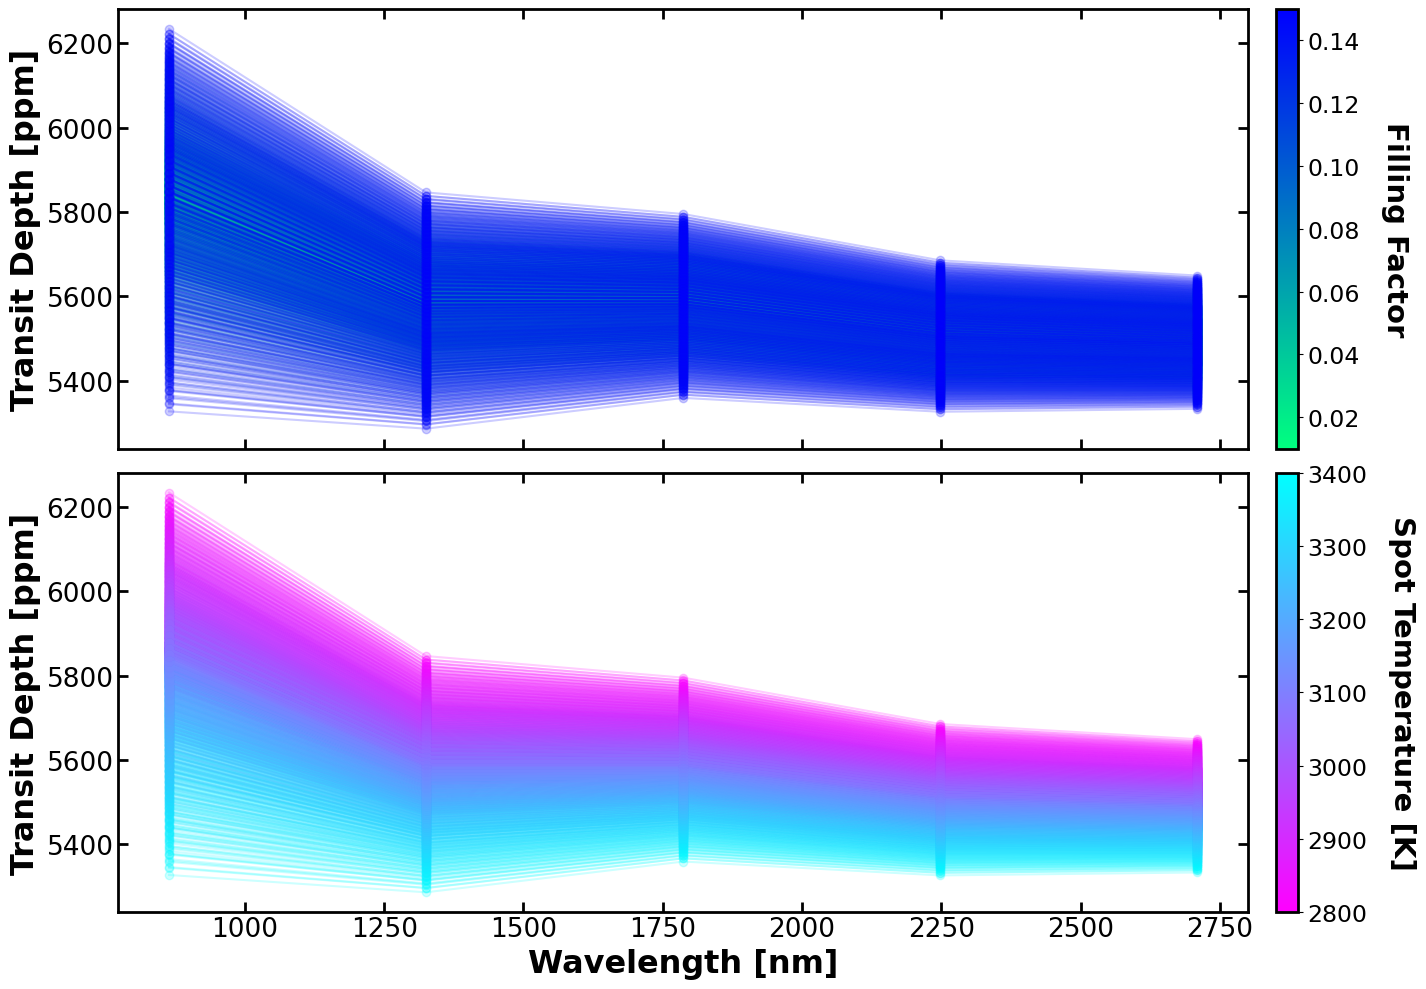

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import os

# Configura os parâmetros visuais padrão
plt.rcParams['axes.linewidth'] = 2  # Aumenta a espessura das bordas dos eixos

# Carregar os dados combinados
data = pd.read_csv(f"interpolated_results_{target}.txt")

# Extrair colunas
f_spot_array = data['ff'].to_numpy(dtype=float)
tempSpot_array = data['T'].to_numpy(dtype=float)
lambdaEff_nm = data['lambdaEff_nm'].to_numpy(dtype=float)
D_lambda = data['D_lambda'].to_numpy(dtype=float)

# Cria a figura com dois subplots (empilhados verticalmente)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

###############################################################################
# Primeiro subplot: Linhas coloridas conforme o filling factor (f_spot)
###############################################################################
# Agrupa as simulações únicas (combinações de f_spot e tempSpot)
unique_simulations = np.unique(np.column_stack((f_spot_array, tempSpot_array)), axis=0)

# Escolhe um colormap e cria o normalizador para f_spot
cmap_f = get_cmap("winter_r")
norm_f = Normalize(f_spot_array.min(), f_spot_array.max())

# Loop para plotar cada simulação
for f_spot, tempSpot in unique_simulations:
    mask = (f_spot_array == f_spot) & (tempSpot_array == tempSpot)
    lambdaEff_sim = lambdaEff_nm[mask]
    D_lambda_sim = D_lambda[mask]
    
    # Define a cor com base no filling factor
    color = cmap_f(norm_f(f_spot))
    ax1.plot(lambdaEff_sim, D_lambda_sim, marker='o', linestyle='-', color=color, alpha=0.2)

# Adiciona a colorbar para o filling factor
sm_f = ScalarMappable(cmap=cmap_f, norm=norm_f)
sm_f.set_array(f_spot_array)
cbar1 = fig.colorbar(sm_f, ax=ax1, orientation='vertical', pad=0.02)
cbar1.set_label("Filling Factor", fontsize=21, fontweight='bold', labelpad=15)
cbar1.ax.tick_params(labelsize=17)
cbar1.ax.yaxis.label.set_rotation(270)  
cbar1.ax.yaxis.label.set_verticalalignment('bottom')  

# Personaliza o primeiro subplot
ax1.set_title("", fontsize=23, fontweight='bold')
ax1.set_xlabel("", fontsize=23, fontweight='bold')
ax1.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
ax1.tick_params(axis="x", direction="in", labelsize=19, width=2, length=7, pad=3, top=True)
ax1.tick_params(axis="y", direction="in", labelsize=19, width=2, length=7, pad=3, right=True)

###############################################################################
# Segundo subplot: Linhas coloridas conforme a spot temperature (T_spot)
###############################################################################
# Filtra os valores válidos de temperatura (não NaN) para a normalização
valid_tempSpot = tempSpot_array[~np.isnan(tempSpot_array)]
if len(valid_tempSpot) == 0:
    raise ValueError("All temperature values are NaN. Check the data.")

# Escolhe um colormap e cria o normalizador para T_spot
cmap_t = get_cmap("cool_r")
norm_t = Normalize(valid_tempSpot.min(), valid_tempSpot.max())

# Loop para plotar cada simulação (desconsiderando as que possuem temperatura NaN)
for f_spot, tempSpot in unique_simulations:
    if np.isnan(tempSpot):
        continue
    mask = (f_spot_array == f_spot) & (tempSpot_array == tempSpot)
    lambdaEff_sim = lambdaEff_nm[mask]
    D_lambda_sim = D_lambda[mask]
    
    # Define a cor com base na spot temperature
    color = cmap_t(norm_t(tempSpot))
    ax2.plot(lambdaEff_sim, D_lambda_sim, marker='o', linestyle='-', color=color, alpha=0.2)

# Adiciona a colorbar para a spot temperature
sm_t = ScalarMappable(cmap=cmap_t, norm=norm_t)
sm_t.set_array(valid_tempSpot)
cbar2 = fig.colorbar(sm_t, ax=ax2, orientation='vertical', pad=0.02)
cbar2.set_label("Spot Temperature [K]", fontsize=21, fontweight='bold', labelpad=15)
cbar2.ax.tick_params(labelsize=17)
cbar2.ax.yaxis.label.set_rotation(270)  
cbar2.ax.yaxis.label.set_verticalalignment('bottom')  

# Personaliza o segundo subplot
ax2.set_title("", fontsize=23, fontweight='bold')
ax2.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
ax2.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
ax2.tick_params(axis="x", direction="in", labelsize=19, width=2, length=7, pad=3, top=True)
ax2.tick_params(axis="y", direction="in", labelsize=19, width=2, length=7, pad=3, right=True)

# Ajusta o layout e exibe a figura
plt.tight_layout()
plt.show()